## Let's try a pretrained car detector with tensorflow

Recently Google has released mobilenet v2 which is a very fast and accurate object detector.  
We will leverage their pretrained models to get quickly up and running with a car detector

In [3]:
from __future__ import print_function

In [4]:
# download and extract the model
import os
import urllib
import urllib2
import tarfile

def download_extract_model(model_download_url):
    fname = os.path.basename(model_download_url)
    print('downloading {}...'.format(fname))
    f = urllib2.urlopen(model_download_url)
    data = f.read()
    with open(fname, "wb") as code:
        code.write(data)
    print('extracting {}'.format(fname))
    if (fname.endswith("tar.gz")):
        tar = tarfile.open(fname, "r:gz")
        tar.extractall()
        tar.close()
# model_download_url = 'http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v2_coco_2018_03_29.tar.gz'
model_download_url = 'http://download.tensorflow.org/models/object_detection/faster_rcnn_resnet101_kitti_2018_01_28.tar.gz'
download_extract_model(model_download_url=model_download_url)


downloading faster_rcnn_resnet101_kitti_2018_01_28.tar.gz...
extracting faster_rcnn_resnet101_kitti_2018_01_28.tar.gz


In [35]:
import os
import tensorflow as tf
# model_name = 'faster_rcnn_resnet101_kitti_2018_01_28'
model_name = 'ssd_mobilenet_v2_coco_2018_03_29'

model_path = os.path.join(os.getcwd(), model_name)
checkpoint_path = os.path.join(model_path, 'frozen_inference_graph.pb')
print(checkpoint_path)
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(checkpoint_path, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

/home/robert/PycharmProjects/Einstein/notebooks/ssd_mobilenet_v2_coco_2018_03_29/frozen_inference_graph.pb


In [36]:
import numpy as np
import tensorflow as tf
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

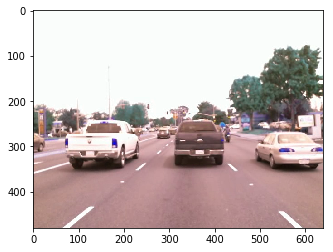

In [37]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
vc = cv2.VideoCapture()
vc.open('../Data/2018-05-05/0013.avi')
vc.set(cv2.CAP_PROP_POS_FRAMES, 200)
_, img = vc.read()
plt.imshow(img)

detections = run_inference_for_single_image(img, detection_graph)

In [38]:
detections.keys()

['num_detections', 'detection_boxes', 'detection_scores', 'detection_classes']

In [39]:
num_detections = detections['num_detections']
detection_boxes = detections['detection_boxes'][:num_detections]
detection_scores = detections['detection_scores'][:num_detections]
detection_classes = detections['detection_classes'][:num_detections]

491.396484375 270.9419631958008 640.0 352.45405197143555


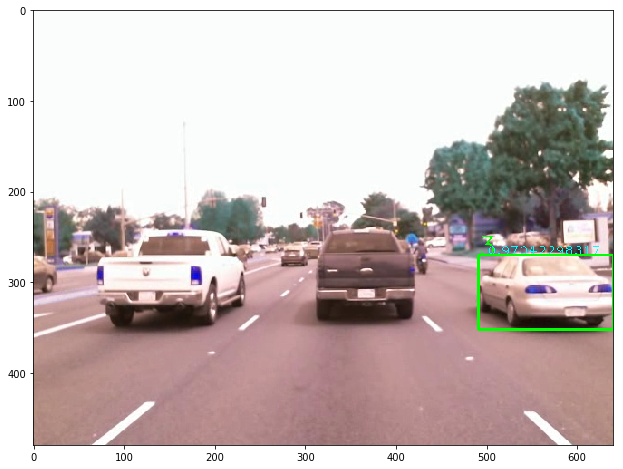

303.7810516357422 238.23205947875977 424.5689392089844 343.8346481323242


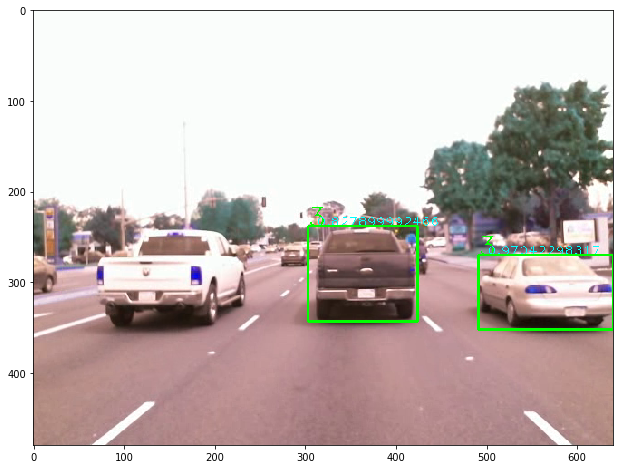

277.10853576660156 259.0696620941162 304.4565200805664 279.4745922088623


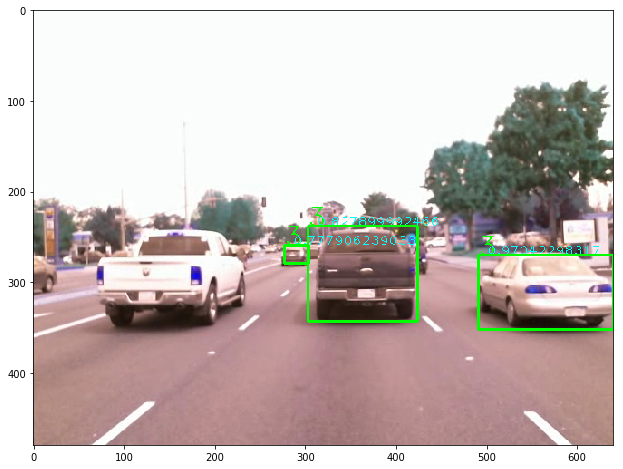

75.62667846679688 240.00869750976562 240.9609603881836 349.79095458984375


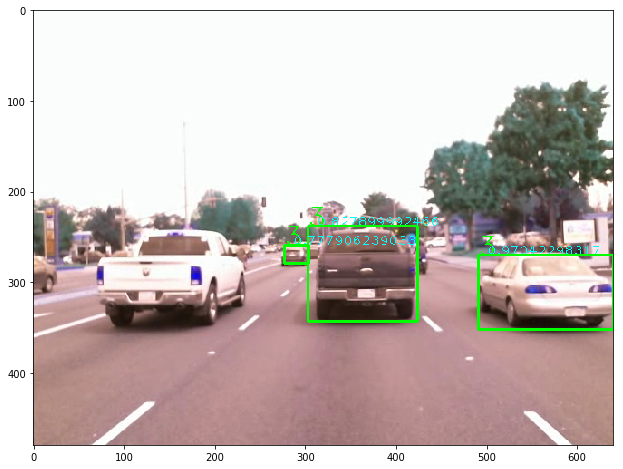

244.4370460510254 254.24474716186523 269.8785209655762 272.0746421813965


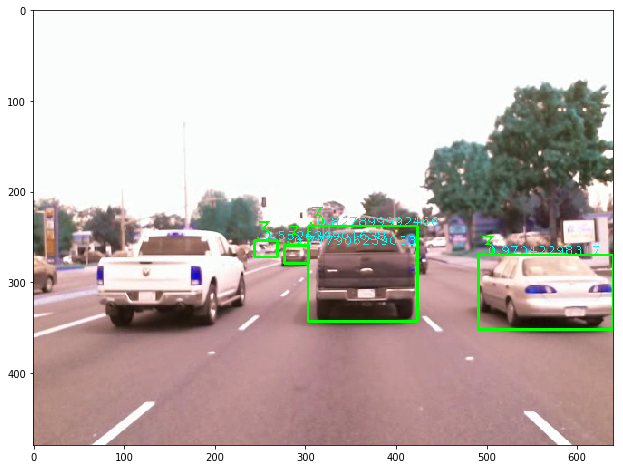

75.62667846679688 240.00869750976562 240.9609603881836 349.79095458984375


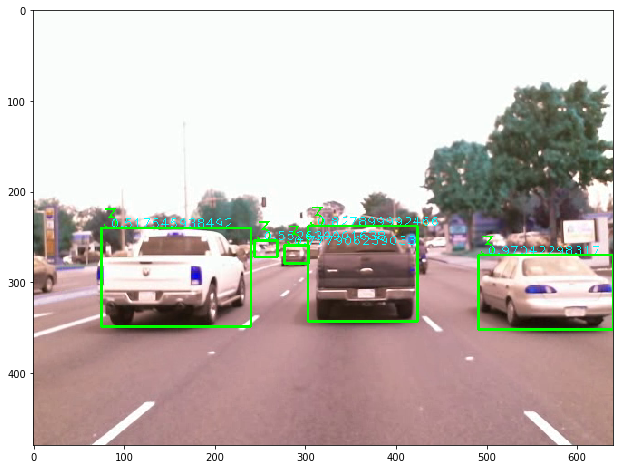

412.37342834472656 249.9609661102295 431.5882873535156 286.79308891296387


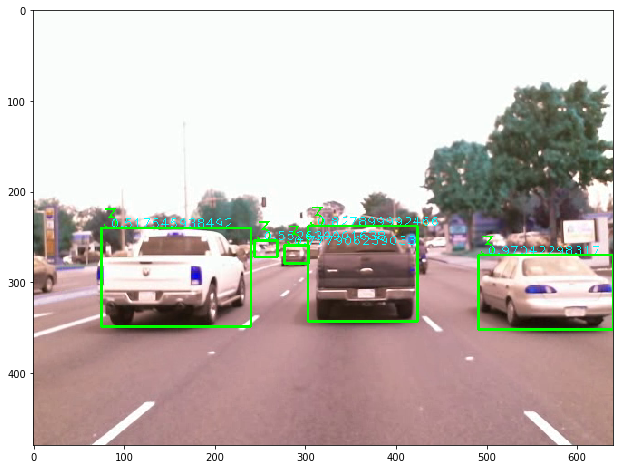

412.37342834472656 249.9609661102295 431.5882873535156 286.79308891296387


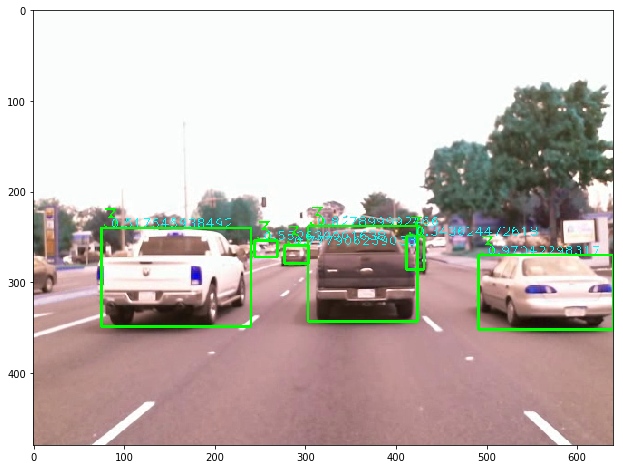

446.9271469116211 247.52540588378906 467.7877426147461 269.7448539733887


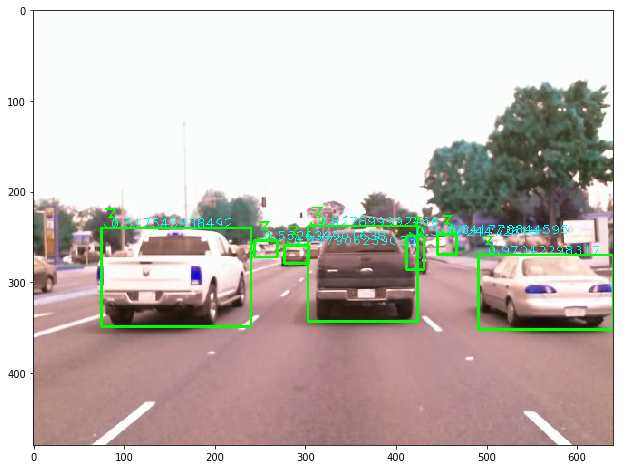

In [46]:
img_width = img.shape[1]
img_height = img.shape[0]
img_draw = img.copy()
for det, cls, score in zip(detection_boxes, detection_classes, detection_scores):
    y1,x1,y2,x2 = det
    x1 *= img_width
    x2 *= img_width
    y1 *= img_height
    y2 *= img_height
    print(x1,y1,x2,y2)
    if int(cls) == 3:
        cv2.putText(img_draw, '{}'.format(cls), (int(x1), int(y1)), 2, 1, (0,255,0))
        cv2.putText(img_draw, '{}'.format(score), (int(x1) + 10, int(y1)), 1, 1, (0,255,255))
        cv2.rectangle(img_draw, (int(x1), int(y1)), (int(x2), int(y2)), (0,255,0), 2)

    plt.figure(figsize=(12,8))
    plt.imshow(img_draw)
    plt.show()